In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Importing libraries
import pandas as pd
import os
import pickle
import random

from matplotlib import pyplot as plt

from src.models import parameter_learning as lfi
from src.models import build_model as build
from src.models import model_schemata as schema
from src.models import inference as inf
from src.visualization import visualize as viz

In [18]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [19]:
experiments = ['noev', 'pev', 'allepev', 'relepev', 'releev', 'releallpev']

In [20]:
data = {}
for exp in experiments:
    with open(f'models/ebdt_data/sub_network/p_model/testing_{exp}_exp5_200i.pkl', 'rb') as f:
        data[exp] = pickle.load(f)

#### Evaluation of learned parameters

Average JSD per experiment pair

In [21]:
predicates = ['p_occupancy']

jsd_dict = {}

# Iterate over predicates
for pred in predicates:
    jsd_dict[pred] = lfi.compare_jsds(pred, experiments, data)

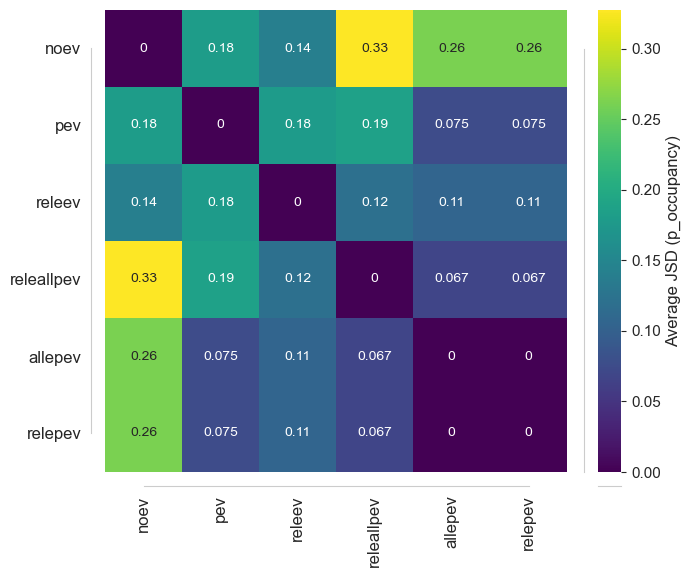

In [22]:
individual_predicate_jsd_heatmap = viz.calc_individual_predicate_jsd_heatmap(experiments, 'p_occupancy', jsd_dict)
viz.plot_clustered_heatmap(individual_predicate_jsd_heatmap, score_type='Average JSD (p_occupancy)')

Average fraction of MaxMatch per experiment pair

In [23]:
predicates = ['p_occupancy']

max_dict = {}

# Iterate over predicates
for pred in predicates:
    max_dict[pred] = lfi.compare_max_categories(pred, experiments, data)

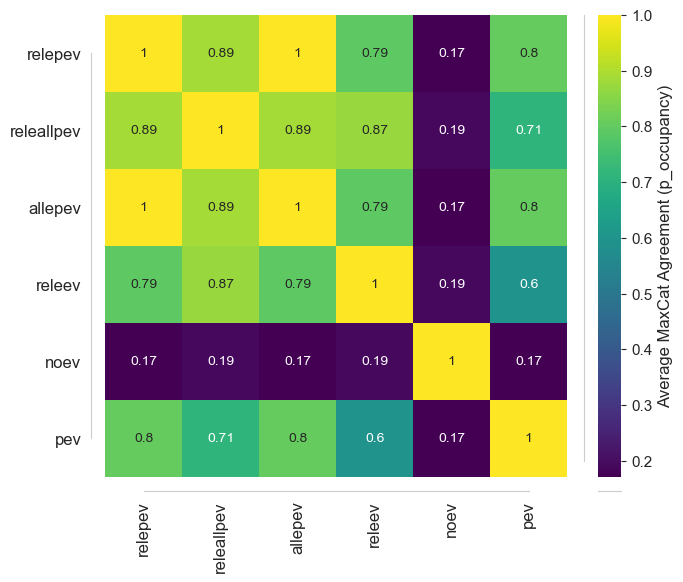

In [24]:
individual_predicate_overlap_heatmap = viz.calc_individual_predicate_overlap_heatmap(experiments, 'p_occupancy', max_dict)
viz.plot_clustered_heatmap(individual_predicate_overlap_heatmap, score_type='Average MaxCat Agreement (p_occupancy)')

#### Compare AUC (all experiments)

In [25]:
p_fc = pd.read_csv('data/processed/ebdt_data/sub_network_p/p_fc.csv')

In [26]:
p_fc['p_base'] = 1 - p_fc['p_dec'] - p_fc['p_inc']
p_fc.loc[p_fc['p_base'] < 0, 'p_base'] = 0
p_fc


,phosphosite,sample,value,prob,p_dec,p_inc,p_base
0,ABI1(Y213),AZD5438,inc,0.897593,0.001000,0.897593,0.101407
1,ANXA2P2(Y24),AZD5438,dec,0.864315,0.864315,0.001000,0.134685
2,ATF1(S198),AZD5438,dec,0.999773,0.999773,0.001000,0.000000
3,BCLAF1(Y284),AZD5438,inc,0.943166,0.001000,0.943166,0.055834
4,HIPK2(Y361),AZD5438,dec,0.729236,0.729236,0.001000,0.269764
...,...,...,...,...,...,...,...
544,HIPK2(Y361),MK2206,dec,0.584604,0.584604,0.001000,0.414396
545,PTTG1IP(Y174),MK2206,dec,0.784317,0.784317,0.001000,0.214683
546,PXN(Y118),MK2206,dec,0.703552,0.703552,0.001000,0.295448
547,PXN(Y88),MK2206,inc,0.576598,0.001000,0.576598,0.422402


In [27]:
# getting sample names (union of all samples in all datasets)
samples = list(set(p_fc['sample']))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.8))
test = [x for x in samples if x not in train]
# filter data
p_fc = p_fc[p_fc['sample'].isin(test)]

In [28]:
analysis_dicts_0 = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0)
analysis_dicts_80 = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0.8)

In [29]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts_0.keys():
    y_onehot_test_list.append(analysis_dicts_0[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_0[exp]['y_score'])
    experiment_names.append(exp)
for exp in analysis_dicts_80.keys():
    y_onehot_test_list.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(f'{exp}_p>0.8')

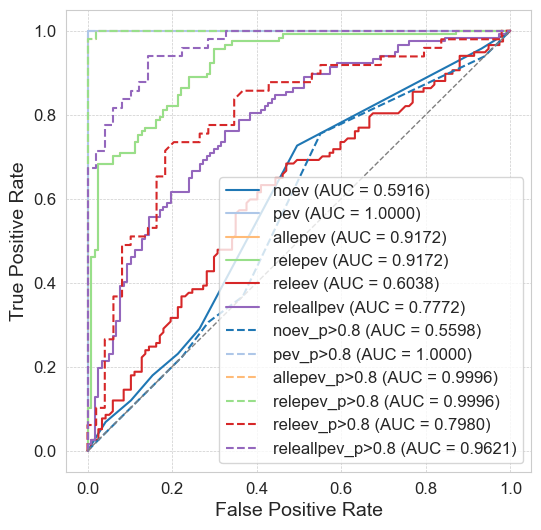

In [30]:
viz.plot_micro_average_roc_seaborn_paired(y_onehot_test_list, y_score_list, experiment_names)